# Robust Scaler - Experimento

Este é um componante que dimensiona atributos usando estatísticas robustas para outliers. Este Scaler remove a mediana e dimensiona os dados de acordo com o intervalo quantil (o padrão é Amplitude interquartil). Amplitude interquartil é o intervalo entre o 1º quartil (25º quantil) e o 3º quartil (75º quantil). Faz uso da implementação do [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html). <br>
Scikit-learn é uma biblioteca open source de machine learning que suporta apredizado supervisionado e não supervisionado. Também provê várias ferramentas para montagem de modelo, pré-processamento de dados, seleção e avaliação de modelos, e muitos outros utilitários.

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [72]:
# parâmetros
dataset = "/tmp/data/Iris-2.csv" #@param {type:"string"}
target = None #@param {type:"feature", label:"Atributo alvo", description: "Esse valor será utilizado para garantir que o alvo não seja removido."}

with_centering = True #@param {type:"boolean", label:"Centralização", description:"Centralizar os dados antes de dimensionar. Ocorre exceção quando usado com matrizes esparsas"}
with_scaling = True #@param {type:"boolean", label:"Dimensionamento", description:"Dimensionar os dados para um intervalo interquartil"}

## Acesso ao conjunto de dados

O conjunto de dados utilizado nesta etapa será o mesmo carregado através da plataforma.<br>
O tipo da variável retornada depende do arquivo de origem:
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) para CSV e compressed CSV: .csv .csv.zip .csv.gz .csv.bz2 .csv.xz
- [Binary IO stream](https://docs.python.org/3/library/io.html#binary-i-o) para outros tipos de arquivo: .jpg .wav .zip .h5 .parquet etc

In [73]:
import pandas as pd

df = pd.read_csv(dataset)

In [74]:
has_target = True if target is not None and target in df.columns else False

In [75]:
X = df.copy()

if has_target:
    X = df.drop(target, axis=1)
    y = df[target]

## Acesso aos metadados do conjunto de dados

Utiliza a função `stat_dataset` do [SDK da PlatIAgro](https://platiagro.github.io/sdk/) para carregar metadados. <br>
Por exemplo, arquivos CSV possuem `metadata['featuretypes']` para cada coluna no conjunto de dados (ex: categorical, numerical, or datetime).

In [76]:
import numpy as np
from platiagro import stat_dataset

metadata = stat_dataset(name=dataset)
featuretypes = metadata["featuretypes"]

columns = df.columns.to_numpy()
featuretypes = np.array(featuretypes)

if has_target:
    target_index = np.argwhere(columns == target)
    columns = np.delete(columns, target_index)
    featuretypes = np.delete(featuretypes, target_index)

## Configuração dos atributos

In [77]:
from platiagro.featuretypes import NUMERICAL

# Selects the indexes of numerical
numerical_indexes = np.where(featuretypes == NUMERICAL)[0]
non_numerical_indexes = np.where(~(featuretypes == NUMERICAL))[0]

# After the step of the make_column_transformer,
# numerical features are grouped in the beggining of the array
numerical_indexes_after_first_step = np.arange(len(numerical_indexes))

## Treina um modelo usando sklearn.preprocessing.RobustScaler

In [78]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline(
    steps=[
        (
            "imputer",
            make_column_transformer(
                (SimpleImputer(), numerical_indexes), remainder="passthrough"
            ),
        ),
        (
            "robust_scaler",
            make_column_transformer(
                (
                    RobustScaler(
                        with_centering=with_centering, with_scaling=with_scaling
                    ),
                    numerical_indexes_after_first_step,
                ),
                remainder="passthrough",
            ),
        ),
    ]
)

# Train model and transform dataset
X = pipeline.fit_transform(X)

# Put numerical features in the lowest indexes
features_after_pipeline = np.concatenate(
    (columns[numerical_indexes], columns[non_numerical_indexes])
)


In [79]:
# Put data back in a pandas.DataFrame
df = pd.DataFrame(data=X, columns=features_after_pipeline)

if has_target:
    df[target] = y

## Cria visualização do resultado

Cria visualização do resultado como uma planilha.

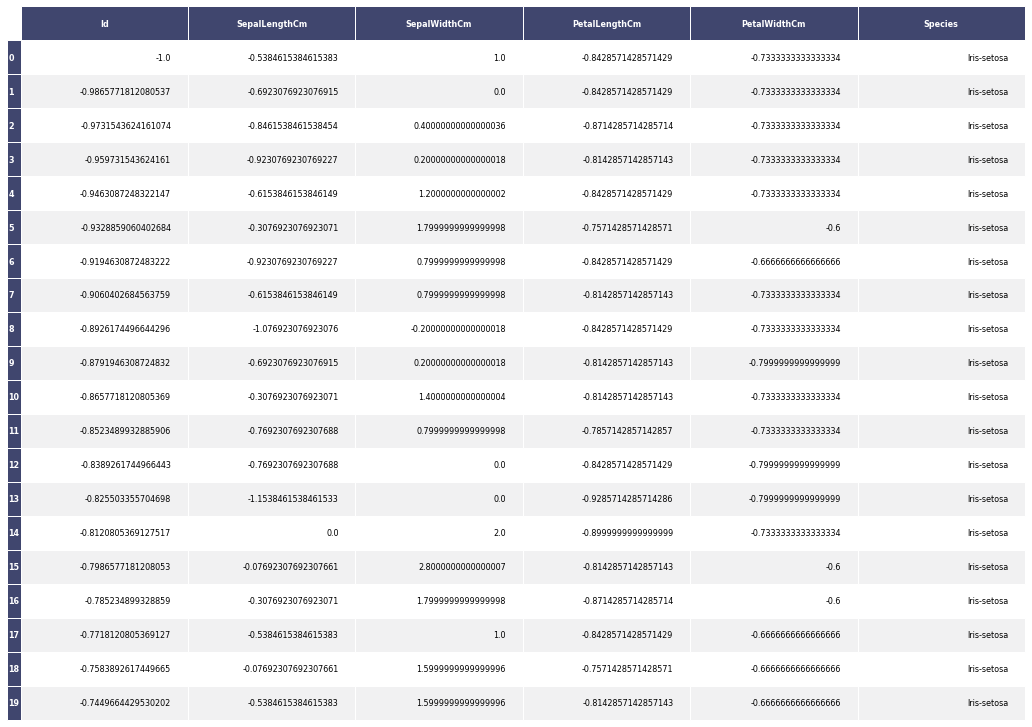

In [80]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table

ax = plot_data_table(df)
plt.show()

## Salva alterações no conjunto de dados

O conjunto de dados será salvo (e sobrescrito com as respectivas mudanças) localmente, no container da experimentação, utilizando a função `pandas.DataFrame.to_csv`.<br>

### Função que mostra os valores antigos e novos para efeito de comparação e para sabermos quais colunas foram alteradas

In [81]:
def description():
    
    new_df = pd.DataFrame({'Columns':[], 'Old_value':[], 'New_value':[], 'Type':[]})
    number = np.random.randint(len(df) ,size=1)[0]
    
    if number == 0:
        number += 1
    
    new_sample = df[columns[numerical_indexes]].iloc[number-1:number].values.tolist()[0]
    old_sample = pd.read_csv(dataset)[columns[numerical_indexes]].iloc[number-1:number].values.tolist()[0]
    
    for i in range(len(columns[numerical_indexes])):
        new_df.loc[len(new_df)] = [columns[numerical_indexes][i], old_sample[i], new_sample[i], featuretypes[numerical_indexes][i]]
    
    return new_df
    

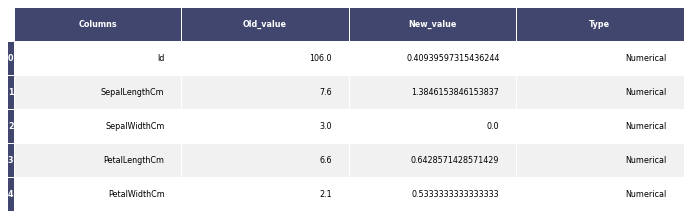

In [82]:
ax = plot_data_table(description())
plt.show()

In [ ]:
# save dataset changes
df.to_csv(dataset, index=False)

## Salva resultados da tarefa 

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.

In [ ]:
from joblib import dump

artifacts = {
    "pipeline": pipeline,
    "columns": columns,
    "features_after_pipeline": features_after_pipeline,
}

dump(artifacts, "/tmp/data/robust-scaler.joblib")